In [13]:
import pandas as pd
from pandas import read_csv
from pandas.api.types import is_numeric_dtype
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score

In [2]:
dataset = read_csv('/Users/Cristy/Downloads/task1/X_train.csv')
dataset.drop('id',axis=1)
y_train=read_csv('/Users/Cristy/Downloads/task1/y_train.csv')
dataset['y']=y_train.y

#### Missing values

In [3]:
dataset.isnull().mean().max()

0.10313531353135313

In [4]:
sorted_corrs=dataset.corr().unstack().sort_values().drop_duplicates()
sorted_corrs[abs(sorted_corrs)>0.95]

x583  x781   -0.998868
x149  x44    -0.989274
x776  x44    -0.986671
x541  x123   -0.985274
      x618   -0.985027
                ...   
x738  x525    0.997610
x548  x474    0.998274
      x537    0.998327
x534  x55     0.998626
id    id      1.000000
Length: 75, dtype: float64

Too many highly correlated features!

In [5]:
df_num_corr=dataset.corr()['y'][:-1]
golden_features_list = df_num_corr[abs(df_num_corr) > 0.4].sort_values(ascending=False)
print("There is {} correlated values with y:\n{}".format(len(golden_features_list), golden_features_list))

There is 15 correlated values with y:
x617    0.463821
x529    0.454451
x737    0.447012
x480    0.440181
x11     0.439012
x118    0.437055
x252    0.413497
x695   -0.402559
x245   -0.412564
x635   -0.438559
x757   -0.439959
x87    -0.446707
x595   -0.447642
x130   -0.451269
x346   -0.474009
Name: y, dtype: float64


Correlation between 'highly correlated with y' features

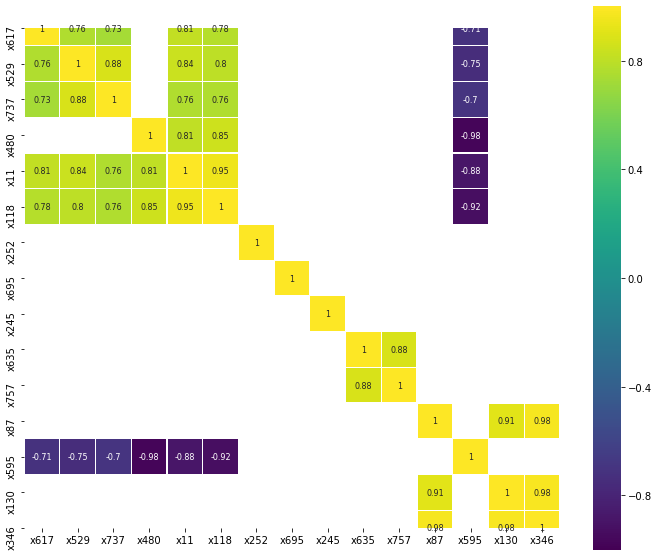

In [6]:
corr=dataset[golden_features_list.index.values].corr()
plt.figure(figsize=(12,10))

sns.heatmap(corr[(corr >= 0.7) | (corr <= -0.7)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True)

Fill-in with median 

In [7]:
df2=dataset.fillna(dataset.median())

variables which are not correlated with response variable

In [8]:
df_num_corr=df2.corr()['y'][:-1]
no_corr_list = df_num_corr[abs(df_num_corr) < 0.01].sort_values(ascending=False)

### Feature selection

new subset:

In [9]:
nocor=pd.Series(no_corr_list).sort_values()
df_nocor=df2.drop([x for x in nocor.index],axis=1)

In [10]:

features= np.array(df_nocor.drop('y', axis = 1))
labels=np.array(df_nocor['y'])
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf=rf.fit(features,labels)
rf.feature_importances_
sfm=SelectFromModel(rf,prefit=True)
features_new=sfm.transform(features)


In [11]:
features_new.shape

(1212, 75)

## Random Forest

In [14]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features_new, labels, test_size = 0.25, random_state = 42)


rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels);

predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
        
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)

# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')



score = r2_score(test_labels, predictions)

print(score)


Mean Absolute Error: 4.91 degrees.
Accuracy: 92.5 %.
0.5453738083958655


### Test set


In [15]:
test = read_csv('/Users/Cristy/Downloads/task1/X_test.csv')
test.drop('id',axis=1)
df2=test.fillna(dataset.median())
test_nocor=df2.drop([x for x in nocor.index],axis=1)
test_features=np.array(test_nocor)
test_features_new=sfm.transform(test_features)
predictions = rf.predict(test_features_new)


In [17]:
out = pd.DataFrame({'id':[float(i) for i in range(0,len(test_features_new))],'y':predictions})
out.to_csv("sampleRF.csv",index=False)